# LightGBM with recent lagged features

This model is different from thew other LightGBM because, besides classical lagged features, we add recent lags, i.e. lag_1 to lag_13.   
We previously excluded those values not to introduce a data leakage (remember the forecasting horizon is 13 weeks).  
In order not to introduce one, we will put NA values on lags 1 to 12 incrementally on the forecasting horizon, i.e.
- Forecast day 1: we have all lags
- Forecast day 2: lag1 is missing  
...
- Forecast day 13: lags 1 to 12 are missing


As expected, lag1 becomes the most important feature. Again, as expected, this introduces a bias while predicting because the majority of the most important features are missing at inference.  
One strategy we try is to randomly introduce NA values in the training set with increasing probabilities from lag1 to lag 12.  
From the feature importance plot we can see that there is an effect but still the performances are worse than a normal lightGBM without recent lags.

---

1. **Load and preprocess**

2. **Add recent lags**

3. **Hyperparameters validation**  
   
4. **Model evaluation**  

5. **Visualisation**  

## 1. Load and preprocess

In [2]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from utils.utils_models import LightGBMForecastingModel
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor

import utils.utils as utils
import utils.utils_features as utils_features
import utils.utils_preprocessing as utils_preprocessing
import utils.utils_plots as utils_plots
import utils.constants as constants

sns.set_theme(style="darkgrid")

In [3]:
df_kaggle = pd.read_csv(constants.file_path)
df_agg = utils.aggregate_df(df_kaggle)

cols = [x for x in df_agg.columns if 'inventory_units_' in x or 'sales_units_' in x]
df_agg = df_agg.drop(columns=cols)

In [4]:
df_agg = utils_preprocessing.preprocess_columns(df_agg, bottom_up=False).drop_duplicates()


# Generate features
df_agg = utils_features.features_time_related(df_agg)
df_agg = utils_features.features_lag(df=df_agg, col='inventory_units', lags=range(1,16), group_column='product_number')
df_agg = utils_features.features_lag(df=df_agg, col='sales_units', lags=[13, 14, 15], group_column='product_number')
df_agg = utils_features.features_rolling(df=df_agg, col='inventory_units', window_sizes=[4, 8], group_column='product_number')
df_agg = utils_features.features_rolling(df=df_agg, col='sales_units', window_sizes=[4, 8], group_column='product_number')
df_agg = utils_features.create_periods_feature(df_agg, coll_agg='product_number', date_column='date', target_col='inventory_units')

df_agg = df_agg.rename(columns={'inventory_units': 'y'}).set_index('date').sort_index()

/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["first_nonzero_signal"] = df.groupby(coll_agg)["signal_above_zero"].cumsum() > 0
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["feature_periods"] = df.groupby(coll_agg).cumcount() + 1


## 2. Effect of adding recent lags

In [5]:
cols_lag = [x for x in df_agg.columns if 'lag' in x and 'inventory_units' in x]
df_agg[df_agg['product_number'] == 234906].tail(13)[cols_lag]

,inventory_units_lag_1,inventory_units_lag_2,inventory_units_lag_3,inventory_units_lag_4,inventory_units_lag_5,inventory_units_lag_6,inventory_units_lag_7,inventory_units_lag_8,inventory_units_lag_9,inventory_units_lag_10,inventory_units_lag_11,inventory_units_lag_12,inventory_units_lag_13,inventory_units_lag_14,inventory_units_lag_15
date,,,,,,,,,,,,,,,
2023-02-11,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0,49.0,27.0,23.0,15.0,9.0,9.0,17.0
2023-02-18,127.0,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0,49.0,27.0,23.0,15.0,9.0,9.0
2023-02-25,64.0,127.0,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0,49.0,27.0,23.0,15.0,9.0
2023-03-04,42.0,64.0,127.0,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0,49.0,27.0,23.0,15.0
2023-03-11,39.0,42.0,64.0,127.0,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0,49.0,27.0,23.0
2023-03-18,55.0,39.0,42.0,64.0,127.0,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0,49.0,27.0
2023-03-25,89.0,55.0,39.0,42.0,64.0,127.0,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0,49.0
2023-04-01,135.0,89.0,55.0,39.0,42.0,64.0,127.0,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0
2023-04-08,125.0,135.0,89.0,55.0,39.0,42.0,64.0,127.0,128.0,77.0,62.0,44.0,44.0,78.0,67.0


In [6]:
df_temp = utils_features.put_na_on_future_lags(df=df_agg, df_key='product_number', ts_name='inventory_units')

/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.where(np.arange(m)[:, None] > np.arange(n), np.nan, df)
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.where(np.arange(m)[:, None] > np.arange(n), np.nan, df)
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [7]:
df_temp[df_temp['product_number'] == 234906].tail(13)[cols_lag]

,inventory_units_lag_1,inventory_units_lag_2,inventory_units_lag_3,inventory_units_lag_4,inventory_units_lag_5,inventory_units_lag_6,inventory_units_lag_7,inventory_units_lag_8,inventory_units_lag_9,inventory_units_lag_10,inventory_units_lag_11,inventory_units_lag_12,inventory_units_lag_13,inventory_units_lag_14,inventory_units_lag_15
date,,,,,,,,,,,,,,,
2023-02-11,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0,49.0,27.0,23.0,15.0,9.0,9.0,17.0
2023-02-18,NaN,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0,49.0,27.0,23.0,15.0,9.0,9.0
2023-02-25,NaN,NaN,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0,49.0,27.0,23.0,15.0,9.0
2023-03-04,NaN,NaN,NaN,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0,49.0,27.0,23.0,15.0
2023-03-11,NaN,NaN,NaN,NaN,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0,49.0,27.0,23.0
2023-03-18,NaN,NaN,NaN,NaN,NaN,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0,49.0,27.0
2023-03-25,NaN,NaN,NaN,NaN,NaN,NaN,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0,49.0
2023-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.0,77.0,62.0,44.0,44.0,78.0,67.0,99.0
2023-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.0,77.0,62.0,44.0,44.0,78.0,67.0


## 3. Hyperparameters validation

In [8]:
X_train, X_test, y_train, y_test = utils.train_test_split(df_agg, forecasting_horizon=13*2, target_col="y")
cv_split = TimeSeriesSplit(n_splits=10, test_size=13)

In [9]:
parameters = {
    'objective': ['regression'],
    "boosting_type": ["gbdt"],
    'metric': ['rmse'],
    'importance_type': ['split'],
    'verbosity': [-1],
    "max_depth": [-1, 1, 3, 4, 5, 6, 10],
    "num_leaves": [10, 20, 30, 40, 100, 120, 150, 200, 250],
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    "n_estimators": [50, 100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7, 1, 1.2, 1.5],
    "reg_alpha": [0, 0.01, 1, 2, 5, 7, 10, 50, 100],
    "reg_lambda": [0, 0.01, 1, 5, 10, 20, 50, 100]
}


random_search = RandomizedSearchCV(
    estimator=LGBMRegressor(), 
    cv=cv_split, 
    param_distributions=parameters,
    verbose=1
    )
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=13),
                   estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.3, 0.5, 0.7, 1,
                                                             1.2, 1.5],
                                        'importance_type': ['split'],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'max_depth': [-1, 1, 3, 4, 5, 6, 10],
                                        'metric': ['rmse'],
                                        'n_estimators': [50, 100, 300, 500, 700,
                                                         900, 1000],
                                        'num_leaves': [10, 20, 30, 40, 100, 120,
                                                       150, 200, 250],
                                        'objective': ['regression'],
                                        'reg_alpha': [0, 0.01, 1, 2, 5, 7, 10,
                                                      50, 100],
                                        'reg_lambda': [0, 0.01, 1, 5, 10, 20,
                                                       50, 100],
                                        'verbosity': [-1]},
                   verbose=1)

In [10]:
best_model = random_search.best_estimator_
optimal_params = best_model.get_params()

In [11]:
optimal_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.3,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'num_leaves': 120,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 7,
 'reg_lambda': 10,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': -1,
 'metric': 'rmse'}

## 4. Model evaluation

In [4]:
optimal_params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 0.5,
    'importance_type': 'split',
    'learning_rate': 0.5,
    'max_depth': 4,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 1000,
    'n_jobs': None,
    'num_leaves': 120,
    'objective': 'regression',
    'random_state': None,
    'reg_alpha': 2,
    'reg_lambda': 0.01,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'verbosity': -1,
    'metric': 'rmse'
    }

In [12]:
tss = TimeSeriesSplit(2, test_size=13)
fc_model = LightGBMForecastingModel(hyperparameters=optimal_params, bottom_up=False)
results_cv = fc_model.cross_validate(df_agg, n_splits=2, extended_features=True)

/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.where(np.arange(m)[:, None] > np.arange(n), np.nan, df)
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.where(np.arange(m)[:, None] > np.arange(n), np.nan, df)
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Train [2019-04-13 - 2022-11-05]
Predict [2022-11-12 - 2023-02-04]


/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.where(np.arange(m)[:, None] > np.arange(n), np.nan, df)
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.where(np.arange(m)[:, None] > np.arange(n), np.nan, df)
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Train [2019-04-13 - 2023-02-04]
Predict [2023-02-11 - 2023-05-06]
Average RMSE from cross-validation: 112.9080


/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.where(np.arange(m)[:, None] > np.arange(n), np.nan, df)
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.where(np.arange(m)[:, None] > np.arange(n), np.nan, df)
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [13]:
results_cv

np.float64(112.908)

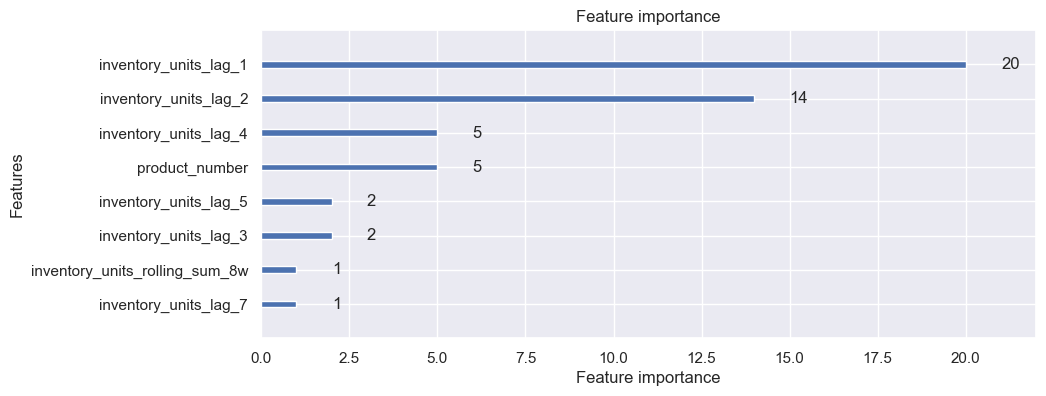

In [14]:
fc_model.plot_feature_importance(importance_type='split')

In [18]:
results_cv = fc_model.cross_validate(df_agg, n_splits=2, extended_features=True, random_na=True)

/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.where(np.arange(m)[:,None] > np.arange(n),np.nan,df)
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.where(np.arange(m)[:,None] > np.arange(n),np.nan,df)
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Train [2019-04-13 - 2022-11-05]
Predict [2022-11-12 - 2023-02-04]


/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.where(np.arange(m)[:,None] > np.arange(n),np.nan,df)
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[:] = np.where(np.arange(m)[:,None] > np.arange(n),np.nan,df)
/Users/matteogiaretti/Python/hp_use_case/utils/utils_features.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Train [2019-04-13 - 2023-02-04]
Predict [2023-02-11 - 2023-05-06]
Average RMSE from cross-validation: 33.7065


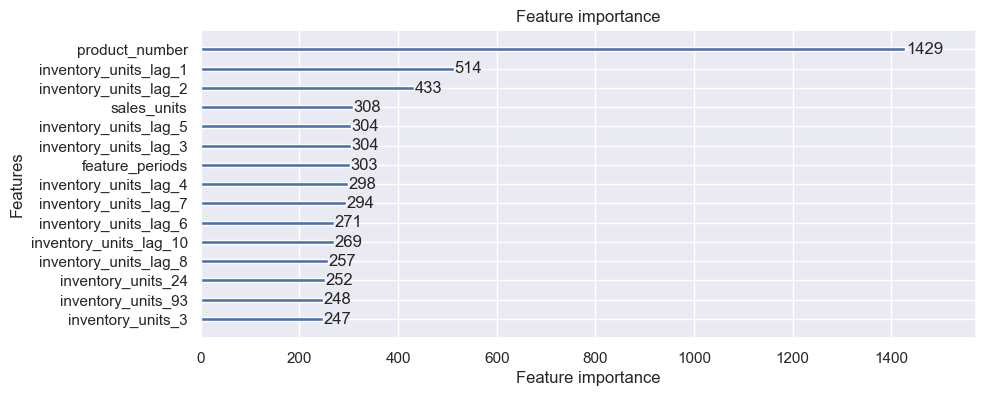

In [20]:
fc_model.plot_feature_importance(importance_type='split')

In [21]:
df_preds = utils.predict_last_13_weeks(df_agg, fc_model, col_agg='product_number')
df_final = df_agg.merge(df_preds.reset_index(), on=['date', 'product_number'], how='left')

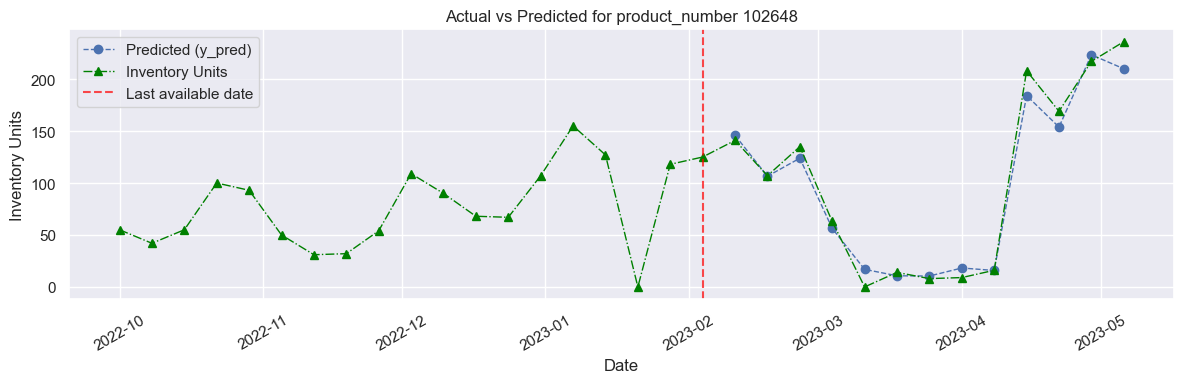

In [22]:
date_present = df_final['date'].max() - pd.DateOffset(weeks=13)
utils_plots.plot_real_vs_predicted(
    df_final.reset_index(), 
    single_ts=102648, 
    pred_columns=['y_pred'], 
    col_agg='product_number', 
    vline_dates=[constants.date_present]
    )